# How to build up a labelled dataset for unet


Here we introduce how to build up dataset for unet.We use one event waveform for example.


# load modules

In [1]:
#!/usr/bin/env python
import os,glob,re
import numpy as np
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import scipy.stats as stats


In [2]:
from quakenet.data_pipeline_unet import DataWriter
import tensorflow as tf
from obspy.core import read,Stream
from quakenet.data_io import load_catalog
from obspy.core.utcdatetime import UTCDateTime
import fnmatch,math
import json

# useful subroutines 

In [3]:
def preprocess_stream(stream):
    stream = stream.detrend('constant')
    ##add by mingzhao,2017/12/2
    stream =stream.filter('bandpass', freqmin=0.5, freqmax=20)
    ##########
    return stream

def write_json(metadata,output_metadata):
    with open(output_metadata, 'w') as outfile:
        json.dump(metadata, outfile)

def normfun(x, mu, sigma):
    pdf = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))
    return pdf

# load event data

In [4]:
#this data has a time range [tp-5,ts+15],tp,ts is manual picks by expert,which is cutted from continous waveform previously
stream_file = "2012-08-30T00:14:25.105000Z.BJ.BBS.00.BHZ.D.SAC"
output_name = "test.tfrecords"
output_path = os.path.join('.', output_name)
writer = DataWriter(output_path)
stream_file1 = re.sub('HZ.D.SAC', 'HE.D.SAC', str(stream_file))
stream_file2 = re.sub('HZ.D.SAC', 'HN.D.SAC', str(stream_file))
stream = read(stream_file)
stream += read(stream_file1)
stream += read(stream_file2)

print ('+ Preprocessing stream',stream)
stream = preprocess_stream(stream)
start_date = stream[0].stats.starttime
end_date = stream[-1].stats.endtime
print("-- Start Date={}, End Date={}".format(start_date, end_date))


('+ Preprocessing stream', <obspy.core.stream.Stream object at 0x7fc0f35ea910>)
-- Start Date=2012-08-29T16:14:20.110001Z, End Date=2012-08-29T16:14:59.330001Z


### resample to 100 sample points,trim it to the window_size,use 0 to fill if the data is not as long as window_size

3 Trace(s) in Stream:
BJ.BBS.00.BHZ | 2012-08-29T16:14:21.110001Z - 2012-08-29T16:14:51.110001Z | 100.0 Hz, 3001 samples
BJ.BBS.00.BHE | 2012-08-29T16:14:21.110001Z - 2012-08-29T16:14:51.110001Z | 100.0 Hz, 3001 samples
BJ.BBS.00.BHN | 2012-08-29T16:14:21.110001Z - 2012-08-29T16:14:51.110001Z | 100.0 Hz, 3001 samples


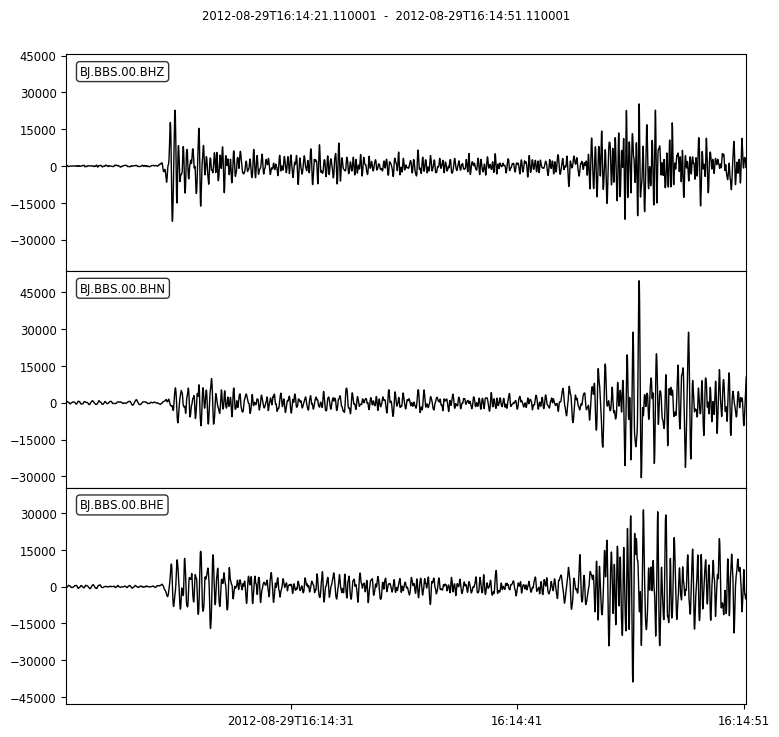

In [5]:
x = np.random.randint(0, 4)
##the cut start randomly before 1~5s of the p arrival,and end after 30s
window_size=30
st_event = stream.resample(100).trim(start_date+x, start_date+x+window_size,pad=True, fill_value=0.0).copy()
print (st_event)
st_event.plot()

### necessary parameters for labelling

In [6]:
n_samples = len(st_event[0].data)
sample_rate = st_event[0].stats.sampling_rate
n_pts = sample_rate * window_size + 1
cluster_id_p = 5-x
cluster_id_s = end_date - start_date-x-15

In [7]:
# p,s and noise labelling

In [8]:
# for p picks
label_obj = st_event.copy()

label_obj[0].data[...] = 1
label_obj[1].data[...] = 0
label_obj[2].data[...] = 0
u1 = cluster_id_p * sample_rate  # mean value miu
lower = int(u1 - 0.5*sample_rate)
upper = int(u1 + 0.5*sample_rate)
label_obj[1].data[lower:upper] = 1

# for s pick
u2 = cluster_id_s * sample_rate  # mean value miu

lower2, upper2 = int(u2 - sample_rate), int(u2 + sample_rate)
try:
    label_obj[2].data[lower2:upper2] = 2
except:
    nnn = int(n_samples) - int(u2 + sample_rate)
    #print  (nnn, n_samples)
    label_obj[2].data[lower2:n_samples] = 2
label_obj.normalize()
label_obj[0].data = label_obj[0].data - label_obj[1].data - label_obj[2].data
writer.write(st_event.copy().normalize(), label_obj)

/home/zm/miniconda3/envs/unet_cea/lib/python2.7/site-packages/obspy/core/trace.py:2176: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


### Plot one trace and its label

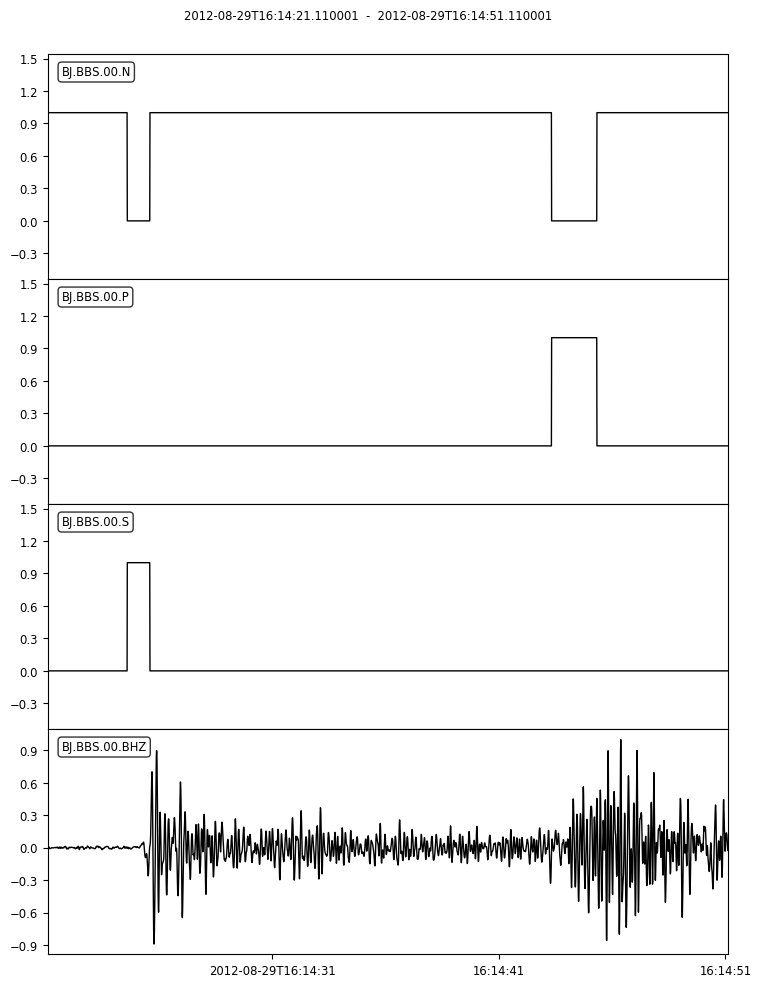

In [9]:
traces = Stream()
traces += st_event[0]
label_obj[0].stats.channel="N"
label_obj[1].stats.channel="S"
label_obj[2].stats.channel="P"
traces += label_obj

traces.normalize().plot()

# (optional) Gaussian label

/home/zm/miniconda3/envs/unet_cea/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


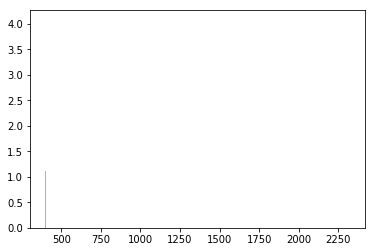

In [10]:
label_obj = st_event.copy()
label_obj[0].data[...] = 1
label_obj[1].data[...] = 0
label_obj[2].data[...] = 0
u1 = cluster_id_p * sample_rate  # mean value miu
lower = int(u1 - 0.2 * sample_rate)
upper = int(u1 + 0.2 * sample_rate)
mu, sigma = u1, 0.1
X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
n, bins, patches = plt.hist(X.rvs(10000), int(0.4*sample_rate), normed=1, alpha=0.5)
label_obj[1].data[lower:upper] = n[0:int(0.4*sample_rate)]

            # for s pick
u2 = cluster_id_s * sample_rate  # mean value miu

lower2, upper2 = int(u2 - 0.2*sample_rate), int(u2 + 0.2*sample_rate)
mu, sigma = u2, 0.1
X = stats.truncnorm((lower2 - mu) / sigma, (upper2 - mu) / sigma, loc=mu, scale=sigma)
n1, bins1, patches1 = plt.hist(X.rvs(10000), int(0.4 * sample_rate), normed=1, alpha=0.5)
try:
    label_obj[2].data[int(u2 - 0.2*sample_rate):int(u2 + 0.2*sample_rate)] = n1[0:int(0.4 * sample_rate)]
                # label_obj.data[int(u2 - sample_rate):int(u2 + sample_rate)] =2
except:
    nnn = int(n_samples) - int(u2 + 0.4*sample_rate)
    print nnn, n_samples
    label_obj[2].data[int(u2 - 0.2*sample_rate):n_samples] = n1[0:nnn]
label_obj.normalize()
label_obj[0].data = label_obj[0].data - label_obj[1].data - label_obj[2].data
writer.write(st_event.copy().normalize(), label_obj)

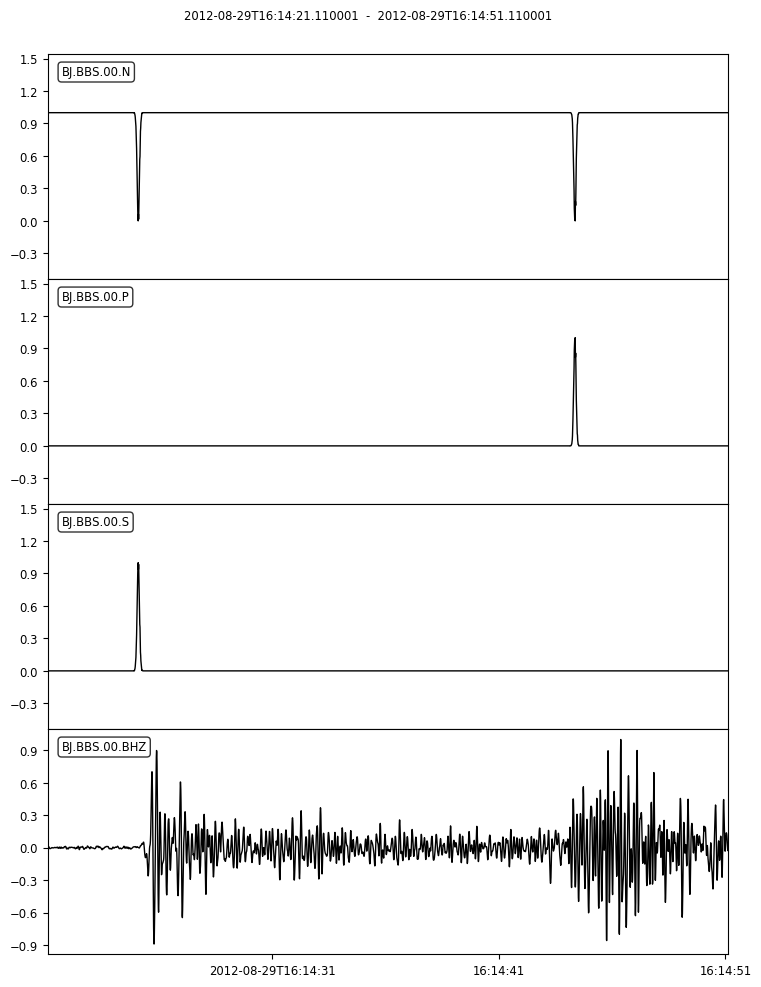

In [11]:
traces = Stream()
traces += st_event[0]
label_obj[0].stats.channel="N"
label_obj[1].stats.channel="S"
label_obj[2].stats.channel="P"
traces += label_obj
traces.normalize().plot()